In [1]:
pip install minisom

In [69]:
from IPython.display import display, Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from minisom import MiniSom
import time
from hyperopt import hp,tpe,fmin,Trials, STATUS_OK

In [70]:
df=pd.read_csv('df_PCA.csv',delimiter=',')

In [71]:
df.set_index('customer_id',inplace=True)

In [72]:
x=int(np.sqrt(5*np.sqrt(df.shape[0])))
y=x
input_len=df.shape[1]

In [73]:
space={'sig':hp.uniform('sig',0.01,x/2.01),'learning_rate':hp.uniform('learning_rate',0.001,0.8)}
def son_fn(space):
  sig=space['sig']
  lr=space['learning_rate']
  val=MiniSom(x=x,y=y,input_len=input_len,sigma=sig,learning_rate=lr).quantization_error(df.values)
  return {'loss': val,'status':STATUS_OK}
trials = Trials()
best=fmin(fn=son_fn,space=space,algo=tpe.suggest,max_evals=200,trials=trials)
print('best:',format(best))

100%|██████████| 200/200 [01:49<00:00,  1.83trial/s, best loss: 1.218626099266434]
best: {'learning_rate': 0.48282222628042604, 'sig': 1.006560378937622}


In [74]:
sigma=best['sig']
learning_rate=best['learning_rate']

In [75]:
print(sigma,learning_rate)

1.006560378937622 0.48282222628042604


In [85]:
sm=MiniSom(x=x,y=y,
            input_len=input_len,
            sigma=sigma,
            learning_rate=learning_rate,
            activation_distance='euclidean',
            neighborhood_function='gaussian',
           random_seed=42
            )
sm.random_weights_init(df.values)
print(np.round(sm.quantization_error(df.values),4),"Starting QE")
sm.train_batch(df.values,100000)
print(np.round(sm.quantization_error(df.values),4),"Ending QE")

/usr/local/lib/python3.10/dist-packages/minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


0.203 Starting QE
0.2014 Ending QE


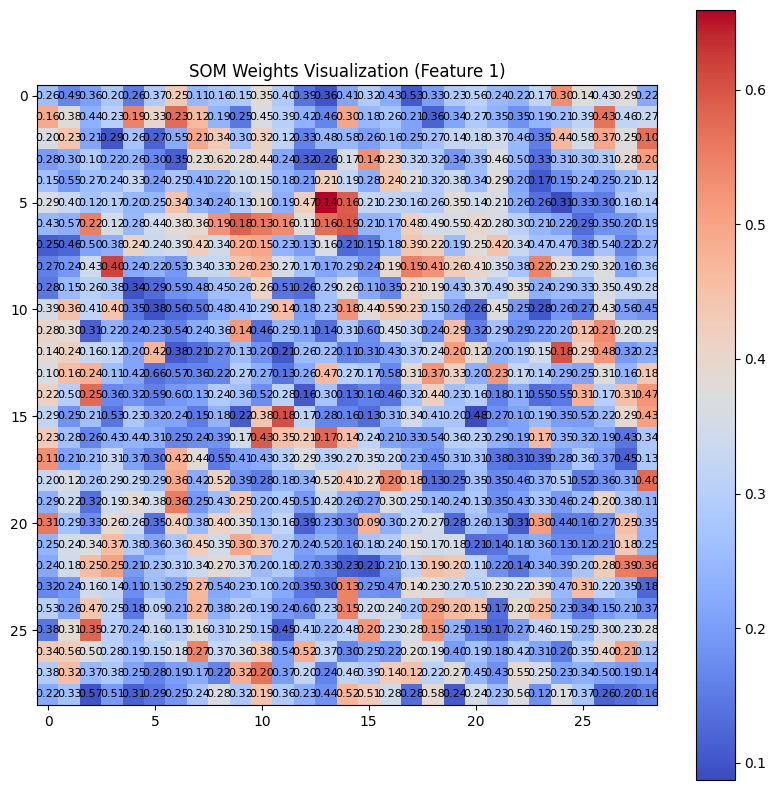

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom

# Assuming `sm` is your trained SOM (MiniSom instance)
weights = sm.get_weights()  # Get the weights of the SOM
x_dim, y_dim = sm.get_weights().shape[:2]
# Plot the SOM weight map
plt.figure(figsize=(10, 10))
for i in range(x_dim):
    for j in range(y_dim):
        # Plot each weight vector at the corresponding grid position (i, j)
        plt.text(i, j, f'{weights[i, j, 0]:.2f}', ha='center', va='center', fontsize=8)

plt.imshow(weights[:,:,0], cmap='coolwarm')  # Visualizing the 1st feature of the weight vector
plt.colorbar()
plt.title('SOM Weights Visualization (Feature 1)')
plt.show()

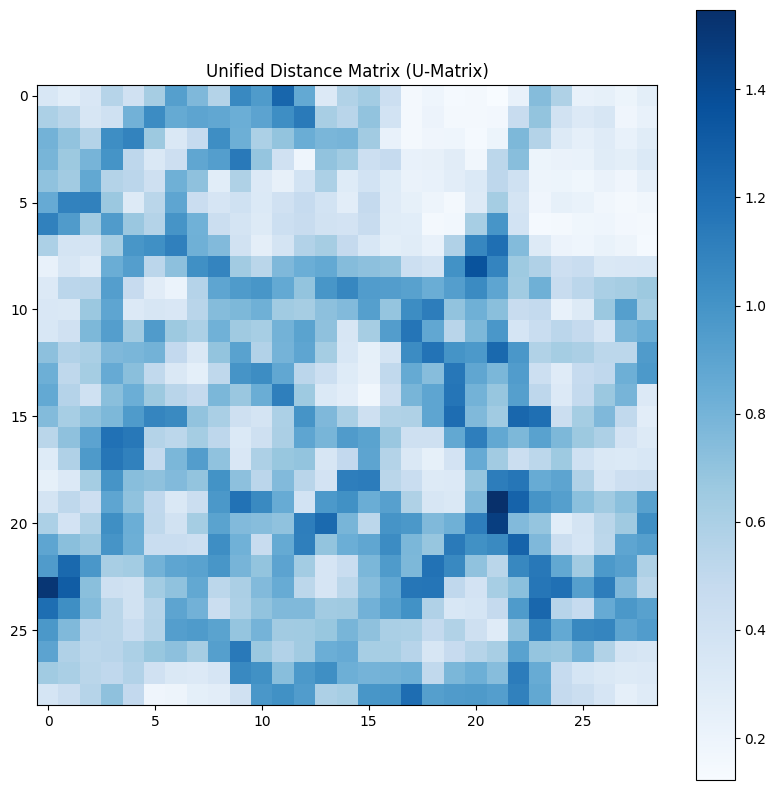

In [90]:
u_matrix = np.zeros((x_dim, y_dim))

for i in range(x_dim):
    for j in range(y_dim):
        # Calculate the distance between the current neuron and its neighbors
        neighbors = []
        if i > 0: neighbors.append(sm.get_weights()[i-1, j, :])
        if i < x_dim-1: neighbors.append(sm.get_weights()[i+1, j, :])
        if j > 0: neighbors.append(sm.get_weights()[i, j-1, :])
        if j < y_dim-1: neighbors.append(sm.get_weights()[i, j+1, :])

        u_matrix[i, j] = np.mean([np.linalg.norm(sm.get_weights()[i, j, :] - neighbor) for neighbor in neighbors])

# Plot the U-Matrix
plt.figure(figsize=(10, 10))
plt.imshow(u_matrix, cmap='Blues')
plt.colorbar()
plt.title('Unified Distance Matrix (U-Matrix)')
plt.show()